![alt text](../img/header.jpg)

# Exercise x: MODFLOW 6
The purpose of this exercise is to use MODFLOW 6 to simulate the formation of a freshwater lens in an axisymmetric island.  This problem requires use of the Buoyancy Package and the Groundwater Transport (GWT) Model, both of which are included in the mf6beta program, which is not an official USGS release.  The DISU package is used for this problem, which allows an axisymmetric grid to be constructed.  This example is described by Bedekar et al. (2019) in the context of a MODFLOW-USG simulation (https://onlinelibrary.wiley.com/doi/abs/10.1111/gwat.12861).

## Part I. Setup Notebook

In [1]:
%matplotlib inline
import sys
import os
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

import config

print(sys.version)
print('python executable: {}'.format(sys.executable))
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

Executable file found: /Users/langevin/langevin/training/Netherlands2019/mf6flopy2019_classrepo.git/exercises/bin/macos/mf2005
Executable file found: /Users/langevin/langevin/training/Netherlands2019/mf6flopy2019_classrepo.git/exercises/bin/macos/mfnwt
Executable file found: /Users/langevin/langevin/training/Netherlands2019/mf6flopy2019_classrepo.git/exercises/bin/macos/mp7
Executable file found: /Users/langevin/langevin/training/Netherlands2019/mf6flopy2019_classrepo.git/exercises/bin/macos/mt3dms
Executable file found: /Users/langevin/langevin/training/Netherlands2019/mf6flopy2019_classrepo.git/exercises/bin/macos/mt3dusgs
Executable file found: /Users/langevin/langevin/training/Netherlands2019/mf6flopy2019_classrepo.git/exercises/bin/macos/mf6
Executable file found: /Users/langevin/langevin/training/Netherlands2019/mf6flopy2019_classrepo.git/exercises/bin/macos/mf6beta
Executable file found: /Users/langevin/langevin/training/Netherlands2019/mf6flopy2019_classrepo.git/exercises/bin/m

## Part II. Create the Axisymmetric Model Grid

In [2]:
# model info
model_ws = './ex0x-island-axisym'

# grid properties
nlay = 70
nrow = 1
ncol = 101
nodes = nlay * nrow * ncol
delr = 5.
delc = 1.
delz = 0.5
radius_edge = np.linspace(delr, ncol * delr, ncol)

# hydraulic properties
hk = 10.
ss = 1.e-4

In [3]:
# unstructured grid arrays
nja = (ncol - 2) * (nlay - 2) * 5  # interior
nja += 2 * (nlay - 2) * 4 + 2 * (ncol - 2) * 4  # edges (excluding corners)
nja += 4 * 3  # corners

print('Number of nodes: {}'.format(nodes))
print('Number of connections, including diagonal: {}'.format(nja))

iac = np.zeros(nodes, dtype=np.int)
ia = np.zeros(nodes + 1, dtype=np.int)
area = np.zeros(nodes, dtype=np.float)
top = np.zeros(nodes, dtype=np.float)
bot = np.zeros(nodes, dtype=np.float)
ja = np.zeros(nja, dtype=np.int)
cl12 = np.zeros(nja, dtype=np.float)
ihc = np.zeros(nja, dtype=np.int)
hwva = np.zeros(nja, dtype=np.float)

Number of nodes: 7070
Number of connections, including diagonal: 35008


In [4]:
ipos = 0
for k in range(nlay):
    for j in range(ncol):
        
        # diagonal
        n = (k * ncol) + j
        ja[ipos] = n
        a = np.pi * radius_edge[j] ** 2
        if j > 0:
            a -= np.pi * radius_edge[j - 1] ** 2
        area[n] = a
        top[n] = 0. - k * delz
        bot[n] = top[n] - delz
        iac[n] += 1
        ipos += 1
        
        # up
        if k > 0:
            m = n - ncol
            ja[ipos] = m
            iac[n] += 1
            cl12[ipos] = .5 * delz
            hwva[ipos] = a
            ipos += 1
            
        # left
        if j > 0:
            m = n - 1
            ja[ipos] = m
            iac[n] += 1
            cl12[ipos] = .5 * delr
            hwva[ipos] = 2. * np.pi * radius_edge[j - 1]
            ihc[ipos] = 1
            ipos += 1

        # right
        if j < ncol - 1:
            m = n + 1
            ja[ipos] = m
            iac[n] += 1
            cl12[ipos] = .5 * delr
            hwva[ipos] = 2. * np.pi * radius_edge[j]
            ihc[ipos] = 1
            ipos += 1

        # down
        if k < nlay - 1:
            m = n + ncol
            ja[ipos] = m
            iac[n] += 1
            cl12[ipos] = .5 * delz
            hwva[ipos] = a
            ipos += 1
            
        ia[n + 1] = ia[n] + iac[n]

In [5]:
vertices = []
ivert = 0
for x in np.linspace(0, ncol * delr, ncol + 1):
    vertices.append((ivert, x, delc))
    ivert += 1
    vertices.append((ivert, x, 0.))
    ivert+= 1
nvert = len(vertices)

cell2d = []
n = 0
for k in range(nlay):
    for j in range(ncol):
        xc = radius_edge[j] - .5 * delr
        yc = .5 * delc
        iv1 = j * 2
        cell2d.append((n, xc, yc, 4, iv1, iv1 + 1, iv1 + 3, iv1 + 2))
        n += 1

## Part II. Create, Run, and Post-Process MODFLOW 6 Model

In [6]:
# create simulation
sim = flopy.mf6.MFSimulation(#sim_name=model_name, 
                             version='mf6', 
                             exe_name=config.mf6betaexe, 
                             sim_ws=model_ws)

# create tdis package
nper = 1
perlen = 10000.
nstp = 10000
tmult = 1.0
tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                             nper=nper, perioddata=[(perlen, nstp, tmult)])

# create gwf model
gwfname = 'flow'
gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname,
                           save_flows=True)

# create iterative model solution and register the gwf model with it
hclose = 1.e-3
rclose = 1.e-3
outer_maximum = 250
inner_maximum = 600
relaxation_factor = 0.0
ims = flopy.mf6.ModflowIms(sim, fname=gwfname+'.ims', print_option='SUMMARY',
                           complexity='complex',
                           outer_hclose=hclose,
                           outer_maximum=outer_maximum,
                           inner_maximum=inner_maximum,
                           inner_hclose=hclose, 
                           rcloserecord=rclose,
                           relaxation_factor=relaxation_factor)
sim.register_ims_package(ims, [gwf.name])


# dis
dis = flopy.mf6.ModflowGwfdisu(gwf, nodes=nodes, nja=nja,
                               top=top, bot=bot, area=area,
                               iac=iac, ja=ja+1, cl12=cl12,
                               ihc=ihc, hwva=hwva, 
                               nvert=nvert, vertices=vertices, cell2d=cell2d)

# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, strt=0.)

# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=0, k=hk)

# storage
sto = flopy.mf6.ModflowGwfsto(gwf, iconvert=0, ss=ss)

# constant head
chdspd = {0: [((n,), 0.) for n in range(ncol-1, ncol*nlay + ncol-1, ncol)]}
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)

# recharge
rchspd = {0: [((n,), 1.74e-003) for n in range(ncol)]}
rch = flopy.mf6.ModflowGwfrch(gwf, stress_period_data=rchspd)

# buoyancy
buy = flopy.mf6.ModflowGwfbuy(gwf, drhodc=0.7143, hhformulation=True)

# output control
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord='{}.cbc'.format(gwfname),
                            head_filerecord='{}.hds'.format(gwfname),
                            headprintrecord=[
                                ('COLUMNS', 10, 'WIDTH', 15,
                                 'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'ALL')])


# create gwt model
gwtname = 'transport'
gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname)
gwt.name_file.save_flows = True

# create iterative model solution and register the gwt model with it
imsgwt = flopy.mf6.ModflowIms(sim, fname=gwtname+'.ims', print_option='SUMMARY', 
                              outer_hclose=hclose,
                              outer_maximum=outer_maximum,
                              under_relaxation='NONE',
                              inner_maximum=inner_maximum,
                              inner_hclose=hclose, rcloserecord=rclose,
                              linear_acceleration='BICGSTAB',
                              scaling_method='NONE',
                              reordering_method='NONE',
                              relaxation_factor=0.97)
sim.register_ims_package(imsgwt, [gwt.name])

disu = flopy.mf6.ModflowGwtdisu(gwt, nodes=nodes, nja=nja,
                                top=top, bot=bot, area=area,
                                iac=iac, ja=ja+1, cl12=cl12,
                                ihc=ihc, hwva=hwva)

# initial conditions
ic = flopy.mf6.ModflowGwtic(gwt, strt=35.,
                            fname='{}.ic'.format(gwtname))

# advection
adv = flopy.mf6.ModflowGwtadv(gwt, scheme='tvd')

# storage
sto = flopy.mf6.ModflowGwtsto(gwt, porosity=0.1)

# constant concentration
cncspd = {0: [((n,), 35.) for n in range(ncol-1, ncol*nlay + ncol-1, ncol)]}
cnc = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=cncspd)


# sources
sourcerecarray = [()]
ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray,
                            fname='{}.ssm'.format(gwtname))

# output control
oc = flopy.mf6.ModflowGwtoc(gwt,
                            budget_filerecord='{}.cbc'.format(gwtname),
                            concentration_filerecord='{}.ucn'.format(gwtname),
                            concentrationprintrecord=[
                                ('COLUMNS', 10, 'WIDTH', 15,
                                 'DIGITS', 6, 'GENERAL')],
                            saverecord=[('CONCENTRATION', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('CONCENTRATION', 'LAST'),
                                         ('BUDGET', 'LAST')])

gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                 exgmnamea=gwfname, exgmnameb=gwtname)


sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing model flow...
    writing model name file...
    writing package disu...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 70 based on size of stress_period_data
    writing package rch_0...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 101 based on size of stress_period_data
    writing package buy...
    writing package oc...
  writing model transport...
    writing model name file...
    writing package disu...
    writing package ic...
    writing package adv...
    writing package sto...
    writing package cnc...
INFORMATION: maxbound in ('gwt6', 'cnc', 'dimensions') changed to 70 based on size of stress_period_data
    writing package ssm...
    writing package oc...
FloPy 

 Solving:  Stress period:     1    Time step:   123
 Solving:  Stress period:     1    Time step:   124
 Solving:  Stress period:     1    Time step:   125
 Solving:  Stress period:     1    Time step:   126
 Solving:  Stress period:     1    Time step:   127
 Solving:  Stress period:     1    Time step:   128
 Solving:  Stress period:     1    Time step:   129
 Solving:  Stress period:     1    Time step:   130
 Solving:  Stress period:     1    Time step:   131
 Solving:  Stress period:     1    Time step:   132
 Solving:  Stress period:     1    Time step:   133
 Solving:  Stress period:     1    Time step:   134
 Solving:  Stress period:     1    Time step:   135
 Solving:  Stress period:     1    Time step:   136
 Solving:  Stress period:     1    Time step:   137
 Solving:  Stress period:     1    Time step:   138
 Solving:  Stress period:     1    Time step:   139
 Solving:  Stress period:     1    Time step:   140
 Solving:  Stress period:     1    Time step:   141
 Solving:  S

 Solving:  Stress period:     1    Time step:   287
 Solving:  Stress period:     1    Time step:   288
 Solving:  Stress period:     1    Time step:   289
 Solving:  Stress period:     1    Time step:   290
 Solving:  Stress period:     1    Time step:   291
 Solving:  Stress period:     1    Time step:   292
 Solving:  Stress period:     1    Time step:   293
 Solving:  Stress period:     1    Time step:   294
 Solving:  Stress period:     1    Time step:   295
 Solving:  Stress period:     1    Time step:   296
 Solving:  Stress period:     1    Time step:   297
 Solving:  Stress period:     1    Time step:   298
 Solving:  Stress period:     1    Time step:   299
 Solving:  Stress period:     1    Time step:   300
 Solving:  Stress period:     1    Time step:   301
 Solving:  Stress period:     1    Time step:   302
 Solving:  Stress period:     1    Time step:   303
 Solving:  Stress period:     1    Time step:   304
 Solving:  Stress period:     1    Time step:   305
 Solving:  S

 Solving:  Stress period:     1    Time step:   445
 Solving:  Stress period:     1    Time step:   446
 Solving:  Stress period:     1    Time step:   447
 Solving:  Stress period:     1    Time step:   448
 Solving:  Stress period:     1    Time step:   449
 Solving:  Stress period:     1    Time step:   450
 Solving:  Stress period:     1    Time step:   451
 Solving:  Stress period:     1    Time step:   452
 Solving:  Stress period:     1    Time step:   453
 Solving:  Stress period:     1    Time step:   454
 Solving:  Stress period:     1    Time step:   455
 Solving:  Stress period:     1    Time step:   456
 Solving:  Stress period:     1    Time step:   457
 Solving:  Stress period:     1    Time step:   458
 Solving:  Stress period:     1    Time step:   459
 Solving:  Stress period:     1    Time step:   460
 Solving:  Stress period:     1    Time step:   461
 Solving:  Stress period:     1    Time step:   462
 Solving:  Stress period:     1    Time step:   463
 Solving:  S

 Solving:  Stress period:     1    Time step:   603
 Solving:  Stress period:     1    Time step:   604
 Solving:  Stress period:     1    Time step:   605
 Solving:  Stress period:     1    Time step:   606
 Solving:  Stress period:     1    Time step:   607
 Solving:  Stress period:     1    Time step:   608
 Solving:  Stress period:     1    Time step:   609
 Solving:  Stress period:     1    Time step:   610
 Solving:  Stress period:     1    Time step:   611
 Solving:  Stress period:     1    Time step:   612
 Solving:  Stress period:     1    Time step:   613
 Solving:  Stress period:     1    Time step:   614
 Solving:  Stress period:     1    Time step:   615
 Solving:  Stress period:     1    Time step:   616
 Solving:  Stress period:     1    Time step:   617
 Solving:  Stress period:     1    Time step:   618
 Solving:  Stress period:     1    Time step:   619
 Solving:  Stress period:     1    Time step:   620
 Solving:  Stress period:     1    Time step:   621
 Solving:  S

 Solving:  Stress period:     1    Time step:   769
 Solving:  Stress period:     1    Time step:   770
 Solving:  Stress period:     1    Time step:   771
 Solving:  Stress period:     1    Time step:   772
 Solving:  Stress period:     1    Time step:   773
 Solving:  Stress period:     1    Time step:   774
 Solving:  Stress period:     1    Time step:   775
 Solving:  Stress period:     1    Time step:   776
 Solving:  Stress period:     1    Time step:   777
 Solving:  Stress period:     1    Time step:   778
 Solving:  Stress period:     1    Time step:   779
 Solving:  Stress period:     1    Time step:   780
 Solving:  Stress period:     1    Time step:   781
 Solving:  Stress period:     1    Time step:   782
 Solving:  Stress period:     1    Time step:   783
 Solving:  Stress period:     1    Time step:   784
 Solving:  Stress period:     1    Time step:   785
 Solving:  Stress period:     1    Time step:   786
 Solving:  Stress period:     1    Time step:   787
 Solving:  S

 Solving:  Stress period:     1    Time step:   936
 Solving:  Stress period:     1    Time step:   937
 Solving:  Stress period:     1    Time step:   938
 Solving:  Stress period:     1    Time step:   939
 Solving:  Stress period:     1    Time step:   940
 Solving:  Stress period:     1    Time step:   941
 Solving:  Stress period:     1    Time step:   942
 Solving:  Stress period:     1    Time step:   943
 Solving:  Stress period:     1    Time step:   944
 Solving:  Stress period:     1    Time step:   945
 Solving:  Stress period:     1    Time step:   946
 Solving:  Stress period:     1    Time step:   947
 Solving:  Stress period:     1    Time step:   948
 Solving:  Stress period:     1    Time step:   949
 Solving:  Stress period:     1    Time step:   950
 Solving:  Stress period:     1    Time step:   951
 Solving:  Stress period:     1    Time step:   952
 Solving:  Stress period:     1    Time step:   953
 Solving:  Stress period:     1    Time step:   954
 Solving:  S

 Solving:  Stress period:     1    Time step:  1102
 Solving:  Stress period:     1    Time step:  1103
 Solving:  Stress period:     1    Time step:  1104
 Solving:  Stress period:     1    Time step:  1105
 Solving:  Stress period:     1    Time step:  1106
 Solving:  Stress period:     1    Time step:  1107
 Solving:  Stress period:     1    Time step:  1108
 Solving:  Stress period:     1    Time step:  1109
 Solving:  Stress period:     1    Time step:  1110
 Solving:  Stress period:     1    Time step:  1111
 Solving:  Stress period:     1    Time step:  1112
 Solving:  Stress period:     1    Time step:  1113
 Solving:  Stress period:     1    Time step:  1114
 Solving:  Stress period:     1    Time step:  1115
 Solving:  Stress period:     1    Time step:  1116
 Solving:  Stress period:     1    Time step:  1117
 Solving:  Stress period:     1    Time step:  1118
 Solving:  Stress period:     1    Time step:  1119
 Solving:  Stress period:     1    Time step:  1120
 Solving:  S

 Solving:  Stress period:     1    Time step:  1267
 Solving:  Stress period:     1    Time step:  1268
 Solving:  Stress period:     1    Time step:  1269
 Solving:  Stress period:     1    Time step:  1270
 Solving:  Stress period:     1    Time step:  1271
 Solving:  Stress period:     1    Time step:  1272
 Solving:  Stress period:     1    Time step:  1273
 Solving:  Stress period:     1    Time step:  1274
 Solving:  Stress period:     1    Time step:  1275
 Solving:  Stress period:     1    Time step:  1276
 Solving:  Stress period:     1    Time step:  1277
 Solving:  Stress period:     1    Time step:  1278
 Solving:  Stress period:     1    Time step:  1279
 Solving:  Stress period:     1    Time step:  1280
 Solving:  Stress period:     1    Time step:  1281
 Solving:  Stress period:     1    Time step:  1282
 Solving:  Stress period:     1    Time step:  1283
 Solving:  Stress period:     1    Time step:  1284
 Solving:  Stress period:     1    Time step:  1285
 Solving:  S

 Solving:  Stress period:     1    Time step:  1430
 Solving:  Stress period:     1    Time step:  1431
 Solving:  Stress period:     1    Time step:  1432
 Solving:  Stress period:     1    Time step:  1433
 Solving:  Stress period:     1    Time step:  1434
 Solving:  Stress period:     1    Time step:  1435
 Solving:  Stress period:     1    Time step:  1436
 Solving:  Stress period:     1    Time step:  1437
 Solving:  Stress period:     1    Time step:  1438
 Solving:  Stress period:     1    Time step:  1439
 Solving:  Stress period:     1    Time step:  1440
 Solving:  Stress period:     1    Time step:  1441
 Solving:  Stress period:     1    Time step:  1442
 Solving:  Stress period:     1    Time step:  1443
 Solving:  Stress period:     1    Time step:  1444
 Solving:  Stress period:     1    Time step:  1445
 Solving:  Stress period:     1    Time step:  1446
 Solving:  Stress period:     1    Time step:  1447
 Solving:  Stress period:     1    Time step:  1448
 Solving:  S

 Solving:  Stress period:     1    Time step:  1588
 Solving:  Stress period:     1    Time step:  1589
 Solving:  Stress period:     1    Time step:  1590
 Solving:  Stress period:     1    Time step:  1591
 Solving:  Stress period:     1    Time step:  1592
 Solving:  Stress period:     1    Time step:  1593
 Solving:  Stress period:     1    Time step:  1594
 Solving:  Stress period:     1    Time step:  1595
 Solving:  Stress period:     1    Time step:  1596
 Solving:  Stress period:     1    Time step:  1597
 Solving:  Stress period:     1    Time step:  1598
 Solving:  Stress period:     1    Time step:  1599
 Solving:  Stress period:     1    Time step:  1600
 Solving:  Stress period:     1    Time step:  1601
 Solving:  Stress period:     1    Time step:  1602
 Solving:  Stress period:     1    Time step:  1603
 Solving:  Stress period:     1    Time step:  1604
 Solving:  Stress period:     1    Time step:  1605
 Solving:  Stress period:     1    Time step:  1606
 Solving:  S

 Solving:  Stress period:     1    Time step:  1755
 Solving:  Stress period:     1    Time step:  1756
 Solving:  Stress period:     1    Time step:  1757
 Solving:  Stress period:     1    Time step:  1758
 Solving:  Stress period:     1    Time step:  1759
 Solving:  Stress period:     1    Time step:  1760
 Solving:  Stress period:     1    Time step:  1761
 Solving:  Stress period:     1    Time step:  1762
 Solving:  Stress period:     1    Time step:  1763
 Solving:  Stress period:     1    Time step:  1764
 Solving:  Stress period:     1    Time step:  1765
 Solving:  Stress period:     1    Time step:  1766
 Solving:  Stress period:     1    Time step:  1767
 Solving:  Stress period:     1    Time step:  1768
 Solving:  Stress period:     1    Time step:  1769
 Solving:  Stress period:     1    Time step:  1770
 Solving:  Stress period:     1    Time step:  1771
 Solving:  Stress period:     1    Time step:  1772
 Solving:  Stress period:     1    Time step:  1773
 Solving:  S

 Solving:  Stress period:     1    Time step:  1914
 Solving:  Stress period:     1    Time step:  1915
 Solving:  Stress period:     1    Time step:  1916
 Solving:  Stress period:     1    Time step:  1917
 Solving:  Stress period:     1    Time step:  1918
 Solving:  Stress period:     1    Time step:  1919
 Solving:  Stress period:     1    Time step:  1920
 Solving:  Stress period:     1    Time step:  1921
 Solving:  Stress period:     1    Time step:  1922
 Solving:  Stress period:     1    Time step:  1923
 Solving:  Stress period:     1    Time step:  1924
 Solving:  Stress period:     1    Time step:  1925
 Solving:  Stress period:     1    Time step:  1926
 Solving:  Stress period:     1    Time step:  1927
 Solving:  Stress period:     1    Time step:  1928
 Solving:  Stress period:     1    Time step:  1929
 Solving:  Stress period:     1    Time step:  1930
 Solving:  Stress period:     1    Time step:  1931
 Solving:  Stress period:     1    Time step:  1932
 Solving:  S

 Solving:  Stress period:     1    Time step:  2073
 Solving:  Stress period:     1    Time step:  2074
 Solving:  Stress period:     1    Time step:  2075
 Solving:  Stress period:     1    Time step:  2076
 Solving:  Stress period:     1    Time step:  2077
 Solving:  Stress period:     1    Time step:  2078
 Solving:  Stress period:     1    Time step:  2079
 Solving:  Stress period:     1    Time step:  2080
 Solving:  Stress period:     1    Time step:  2081
 Solving:  Stress period:     1    Time step:  2082
 Solving:  Stress period:     1    Time step:  2083
 Solving:  Stress period:     1    Time step:  2084
 Solving:  Stress period:     1    Time step:  2085
 Solving:  Stress period:     1    Time step:  2086
 Solving:  Stress period:     1    Time step:  2087
 Solving:  Stress period:     1    Time step:  2088
 Solving:  Stress period:     1    Time step:  2089
 Solving:  Stress period:     1    Time step:  2090
 Solving:  Stress period:     1    Time step:  2091
 Solving:  S

 Solving:  Stress period:     1    Time step:  2233
 Solving:  Stress period:     1    Time step:  2234
 Solving:  Stress period:     1    Time step:  2235
 Solving:  Stress period:     1    Time step:  2236
 Solving:  Stress period:     1    Time step:  2237
 Solving:  Stress period:     1    Time step:  2238
 Solving:  Stress period:     1    Time step:  2239
 Solving:  Stress period:     1    Time step:  2240
 Solving:  Stress period:     1    Time step:  2241
 Solving:  Stress period:     1    Time step:  2242
 Solving:  Stress period:     1    Time step:  2243
 Solving:  Stress period:     1    Time step:  2244
 Solving:  Stress period:     1    Time step:  2245
 Solving:  Stress period:     1    Time step:  2246
 Solving:  Stress period:     1    Time step:  2247
 Solving:  Stress period:     1    Time step:  2248
 Solving:  Stress period:     1    Time step:  2249
 Solving:  Stress period:     1    Time step:  2250
 Solving:  Stress period:     1    Time step:  2251
 Solving:  S

 Solving:  Stress period:     1    Time step:  2393
 Solving:  Stress period:     1    Time step:  2394
 Solving:  Stress period:     1    Time step:  2395
 Solving:  Stress period:     1    Time step:  2396
 Solving:  Stress period:     1    Time step:  2397
 Solving:  Stress period:     1    Time step:  2398
 Solving:  Stress period:     1    Time step:  2399
 Solving:  Stress period:     1    Time step:  2400
 Solving:  Stress period:     1    Time step:  2401
 Solving:  Stress period:     1    Time step:  2402
 Solving:  Stress period:     1    Time step:  2403
 Solving:  Stress period:     1    Time step:  2404
 Solving:  Stress period:     1    Time step:  2405
 Solving:  Stress period:     1    Time step:  2406
 Solving:  Stress period:     1    Time step:  2407
 Solving:  Stress period:     1    Time step:  2408
 Solving:  Stress period:     1    Time step:  2409
 Solving:  Stress period:     1    Time step:  2410
 Solving:  Stress period:     1    Time step:  2411
 Solving:  S

 Solving:  Stress period:     1    Time step:  2553
 Solving:  Stress period:     1    Time step:  2554
 Solving:  Stress period:     1    Time step:  2555
 Solving:  Stress period:     1    Time step:  2556
 Solving:  Stress period:     1    Time step:  2557
 Solving:  Stress period:     1    Time step:  2558
 Solving:  Stress period:     1    Time step:  2559
 Solving:  Stress period:     1    Time step:  2560
 Solving:  Stress period:     1    Time step:  2561
 Solving:  Stress period:     1    Time step:  2562
 Solving:  Stress period:     1    Time step:  2563
 Solving:  Stress period:     1    Time step:  2564
 Solving:  Stress period:     1    Time step:  2565
 Solving:  Stress period:     1    Time step:  2566
 Solving:  Stress period:     1    Time step:  2567
 Solving:  Stress period:     1    Time step:  2568
 Solving:  Stress period:     1    Time step:  2569
 Solving:  Stress period:     1    Time step:  2570
 Solving:  Stress period:     1    Time step:  2571
 Solving:  S

 Solving:  Stress period:     1    Time step:  2713
 Solving:  Stress period:     1    Time step:  2714
 Solving:  Stress period:     1    Time step:  2715
 Solving:  Stress period:     1    Time step:  2716
 Solving:  Stress period:     1    Time step:  2717
 Solving:  Stress period:     1    Time step:  2718
 Solving:  Stress period:     1    Time step:  2719
 Solving:  Stress period:     1    Time step:  2720
 Solving:  Stress period:     1    Time step:  2721
 Solving:  Stress period:     1    Time step:  2722
 Solving:  Stress period:     1    Time step:  2723
 Solving:  Stress period:     1    Time step:  2724
 Solving:  Stress period:     1    Time step:  2725
 Solving:  Stress period:     1    Time step:  2726
 Solving:  Stress period:     1    Time step:  2727
 Solving:  Stress period:     1    Time step:  2728
 Solving:  Stress period:     1    Time step:  2729
 Solving:  Stress period:     1    Time step:  2730
 Solving:  Stress period:     1    Time step:  2731
 Solving:  S

 Solving:  Stress period:     1    Time step:  2873
 Solving:  Stress period:     1    Time step:  2874
 Solving:  Stress period:     1    Time step:  2875
 Solving:  Stress period:     1    Time step:  2876
 Solving:  Stress period:     1    Time step:  2877
 Solving:  Stress period:     1    Time step:  2878
 Solving:  Stress period:     1    Time step:  2879
 Solving:  Stress period:     1    Time step:  2880
 Solving:  Stress period:     1    Time step:  2881
 Solving:  Stress period:     1    Time step:  2882
 Solving:  Stress period:     1    Time step:  2883
 Solving:  Stress period:     1    Time step:  2884
 Solving:  Stress period:     1    Time step:  2885
 Solving:  Stress period:     1    Time step:  2886
 Solving:  Stress period:     1    Time step:  2887
 Solving:  Stress period:     1    Time step:  2888
 Solving:  Stress period:     1    Time step:  2889
 Solving:  Stress period:     1    Time step:  2890
 Solving:  Stress period:     1    Time step:  2891
 Solving:  S

 Solving:  Stress period:     1    Time step:  3034
 Solving:  Stress period:     1    Time step:  3035
 Solving:  Stress period:     1    Time step:  3036
 Solving:  Stress period:     1    Time step:  3037
 Solving:  Stress period:     1    Time step:  3038
 Solving:  Stress period:     1    Time step:  3039
 Solving:  Stress period:     1    Time step:  3040
 Solving:  Stress period:     1    Time step:  3041
 Solving:  Stress period:     1    Time step:  3042
 Solving:  Stress period:     1    Time step:  3043
 Solving:  Stress period:     1    Time step:  3044
 Solving:  Stress period:     1    Time step:  3045
 Solving:  Stress period:     1    Time step:  3046
 Solving:  Stress period:     1    Time step:  3047
 Solving:  Stress period:     1    Time step:  3048
 Solving:  Stress period:     1    Time step:  3049
 Solving:  Stress period:     1    Time step:  3050
 Solving:  Stress period:     1    Time step:  3051
 Solving:  Stress period:     1    Time step:  3052
 Solving:  S

 Solving:  Stress period:     1    Time step:  3194
 Solving:  Stress period:     1    Time step:  3195
 Solving:  Stress period:     1    Time step:  3196
 Solving:  Stress period:     1    Time step:  3197
 Solving:  Stress period:     1    Time step:  3198
 Solving:  Stress period:     1    Time step:  3199
 Solving:  Stress period:     1    Time step:  3200
 Solving:  Stress period:     1    Time step:  3201
 Solving:  Stress period:     1    Time step:  3202
 Solving:  Stress period:     1    Time step:  3203
 Solving:  Stress period:     1    Time step:  3204
 Solving:  Stress period:     1    Time step:  3205
 Solving:  Stress period:     1    Time step:  3206
 Solving:  Stress period:     1    Time step:  3207
 Solving:  Stress period:     1    Time step:  3208
 Solving:  Stress period:     1    Time step:  3209
 Solving:  Stress period:     1    Time step:  3210
 Solving:  Stress period:     1    Time step:  3211
 Solving:  Stress period:     1    Time step:  3212
 Solving:  S

 Solving:  Stress period:     1    Time step:  3355
 Solving:  Stress period:     1    Time step:  3356
 Solving:  Stress period:     1    Time step:  3357
 Solving:  Stress period:     1    Time step:  3358
 Solving:  Stress period:     1    Time step:  3359
 Solving:  Stress period:     1    Time step:  3360
 Solving:  Stress period:     1    Time step:  3361
 Solving:  Stress period:     1    Time step:  3362
 Solving:  Stress period:     1    Time step:  3363
 Solving:  Stress period:     1    Time step:  3364
 Solving:  Stress period:     1    Time step:  3365
 Solving:  Stress period:     1    Time step:  3366
 Solving:  Stress period:     1    Time step:  3367
 Solving:  Stress period:     1    Time step:  3368
 Solving:  Stress period:     1    Time step:  3369
 Solving:  Stress period:     1    Time step:  3370
 Solving:  Stress period:     1    Time step:  3371
 Solving:  Stress period:     1    Time step:  3372
 Solving:  Stress period:     1    Time step:  3373
 Solving:  S

 Solving:  Stress period:     1    Time step:  3515
 Solving:  Stress period:     1    Time step:  3516
 Solving:  Stress period:     1    Time step:  3517
 Solving:  Stress period:     1    Time step:  3518
 Solving:  Stress period:     1    Time step:  3519
 Solving:  Stress period:     1    Time step:  3520
 Solving:  Stress period:     1    Time step:  3521
 Solving:  Stress period:     1    Time step:  3522
 Solving:  Stress period:     1    Time step:  3523
 Solving:  Stress period:     1    Time step:  3524
 Solving:  Stress period:     1    Time step:  3525
 Solving:  Stress period:     1    Time step:  3526
 Solving:  Stress period:     1    Time step:  3527
 Solving:  Stress period:     1    Time step:  3528
 Solving:  Stress period:     1    Time step:  3529
 Solving:  Stress period:     1    Time step:  3530
 Solving:  Stress period:     1    Time step:  3531
 Solving:  Stress period:     1    Time step:  3532
 Solving:  Stress period:     1    Time step:  3533
 Solving:  S

 Solving:  Stress period:     1    Time step:  3677
 Solving:  Stress period:     1    Time step:  3678
 Solving:  Stress period:     1    Time step:  3679
 Solving:  Stress period:     1    Time step:  3680
 Solving:  Stress period:     1    Time step:  3681
 Solving:  Stress period:     1    Time step:  3682
 Solving:  Stress period:     1    Time step:  3683
 Solving:  Stress period:     1    Time step:  3684
 Solving:  Stress period:     1    Time step:  3685
 Solving:  Stress period:     1    Time step:  3686
 Solving:  Stress period:     1    Time step:  3687
 Solving:  Stress period:     1    Time step:  3688
 Solving:  Stress period:     1    Time step:  3689
 Solving:  Stress period:     1    Time step:  3690
 Solving:  Stress period:     1    Time step:  3691
 Solving:  Stress period:     1    Time step:  3692
 Solving:  Stress period:     1    Time step:  3693
 Solving:  Stress period:     1    Time step:  3694
 Solving:  Stress period:     1    Time step:  3695
 Solving:  S

 Solving:  Stress period:     1    Time step:  3839
 Solving:  Stress period:     1    Time step:  3840
 Solving:  Stress period:     1    Time step:  3841
 Solving:  Stress period:     1    Time step:  3842
 Solving:  Stress period:     1    Time step:  3843
 Solving:  Stress period:     1    Time step:  3844
 Solving:  Stress period:     1    Time step:  3845
 Solving:  Stress period:     1    Time step:  3846
 Solving:  Stress period:     1    Time step:  3847
 Solving:  Stress period:     1    Time step:  3848
 Solving:  Stress period:     1    Time step:  3849
 Solving:  Stress period:     1    Time step:  3850
 Solving:  Stress period:     1    Time step:  3851
 Solving:  Stress period:     1    Time step:  3852
 Solving:  Stress period:     1    Time step:  3853
 Solving:  Stress period:     1    Time step:  3854
 Solving:  Stress period:     1    Time step:  3855
 Solving:  Stress period:     1    Time step:  3856
 Solving:  Stress period:     1    Time step:  3857
 Solving:  S

 Solving:  Stress period:     1    Time step:  4004
 Solving:  Stress period:     1    Time step:  4005
 Solving:  Stress period:     1    Time step:  4006
 Solving:  Stress period:     1    Time step:  4007
 Solving:  Stress period:     1    Time step:  4008
 Solving:  Stress period:     1    Time step:  4009
 Solving:  Stress period:     1    Time step:  4010
 Solving:  Stress period:     1    Time step:  4011
 Solving:  Stress period:     1    Time step:  4012
 Solving:  Stress period:     1    Time step:  4013
 Solving:  Stress period:     1    Time step:  4014
 Solving:  Stress period:     1    Time step:  4015
 Solving:  Stress period:     1    Time step:  4016
 Solving:  Stress period:     1    Time step:  4017
 Solving:  Stress period:     1    Time step:  4018
 Solving:  Stress period:     1    Time step:  4019
 Solving:  Stress period:     1    Time step:  4020
 Solving:  Stress period:     1    Time step:  4021
 Solving:  Stress period:     1    Time step:  4022
 Solving:  S

 Solving:  Stress period:     1    Time step:  4170
 Solving:  Stress period:     1    Time step:  4171
 Solving:  Stress period:     1    Time step:  4172
 Solving:  Stress period:     1    Time step:  4173
 Solving:  Stress period:     1    Time step:  4174
 Solving:  Stress period:     1    Time step:  4175
 Solving:  Stress period:     1    Time step:  4176
 Solving:  Stress period:     1    Time step:  4177
 Solving:  Stress period:     1    Time step:  4178
 Solving:  Stress period:     1    Time step:  4179
 Solving:  Stress period:     1    Time step:  4180
 Solving:  Stress period:     1    Time step:  4181
 Solving:  Stress period:     1    Time step:  4182
 Solving:  Stress period:     1    Time step:  4183
 Solving:  Stress period:     1    Time step:  4184
 Solving:  Stress period:     1    Time step:  4185
 Solving:  Stress period:     1    Time step:  4186
 Solving:  Stress period:     1    Time step:  4187
 Solving:  Stress period:     1    Time step:  4188
 Solving:  S

 Solving:  Stress period:     1    Time step:  4335
 Solving:  Stress period:     1    Time step:  4336
 Solving:  Stress period:     1    Time step:  4337
 Solving:  Stress period:     1    Time step:  4338
 Solving:  Stress period:     1    Time step:  4339
 Solving:  Stress period:     1    Time step:  4340
 Solving:  Stress period:     1    Time step:  4341
 Solving:  Stress period:     1    Time step:  4342
 Solving:  Stress period:     1    Time step:  4343
 Solving:  Stress period:     1    Time step:  4344
 Solving:  Stress period:     1    Time step:  4345
 Solving:  Stress period:     1    Time step:  4346
 Solving:  Stress period:     1    Time step:  4347
 Solving:  Stress period:     1    Time step:  4348
 Solving:  Stress period:     1    Time step:  4349
 Solving:  Stress period:     1    Time step:  4350
 Solving:  Stress period:     1    Time step:  4351
 Solving:  Stress period:     1    Time step:  4352
 Solving:  Stress period:     1    Time step:  4353
 Solving:  S

 Solving:  Stress period:     1    Time step:  4495
 Solving:  Stress period:     1    Time step:  4496
 Solving:  Stress period:     1    Time step:  4497
 Solving:  Stress period:     1    Time step:  4498
 Solving:  Stress period:     1    Time step:  4499
 Solving:  Stress period:     1    Time step:  4500
 Solving:  Stress period:     1    Time step:  4501
 Solving:  Stress period:     1    Time step:  4502
 Solving:  Stress period:     1    Time step:  4503
 Solving:  Stress period:     1    Time step:  4504
 Solving:  Stress period:     1    Time step:  4505
 Solving:  Stress period:     1    Time step:  4506
 Solving:  Stress period:     1    Time step:  4507
 Solving:  Stress period:     1    Time step:  4508
 Solving:  Stress period:     1    Time step:  4509
 Solving:  Stress period:     1    Time step:  4510
 Solving:  Stress period:     1    Time step:  4511
 Solving:  Stress period:     1    Time step:  4512
 Solving:  Stress period:     1    Time step:  4513
 Solving:  S

 Solving:  Stress period:     1    Time step:  4663
 Solving:  Stress period:     1    Time step:  4664
 Solving:  Stress period:     1    Time step:  4665
 Solving:  Stress period:     1    Time step:  4666
 Solving:  Stress period:     1    Time step:  4667
 Solving:  Stress period:     1    Time step:  4668
 Solving:  Stress period:     1    Time step:  4669
 Solving:  Stress period:     1    Time step:  4670
 Solving:  Stress period:     1    Time step:  4671
 Solving:  Stress period:     1    Time step:  4672
 Solving:  Stress period:     1    Time step:  4673
 Solving:  Stress period:     1    Time step:  4674
 Solving:  Stress period:     1    Time step:  4675
 Solving:  Stress period:     1    Time step:  4676
 Solving:  Stress period:     1    Time step:  4677
 Solving:  Stress period:     1    Time step:  4678
 Solving:  Stress period:     1    Time step:  4679
 Solving:  Stress period:     1    Time step:  4680
 Solving:  Stress period:     1    Time step:  4681
 Solving:  S

 Solving:  Stress period:     1    Time step:  4821
 Solving:  Stress period:     1    Time step:  4822
 Solving:  Stress period:     1    Time step:  4823
 Solving:  Stress period:     1    Time step:  4824
 Solving:  Stress period:     1    Time step:  4825
 Solving:  Stress period:     1    Time step:  4826
 Solving:  Stress period:     1    Time step:  4827
 Solving:  Stress period:     1    Time step:  4828
 Solving:  Stress period:     1    Time step:  4829
 Solving:  Stress period:     1    Time step:  4830
 Solving:  Stress period:     1    Time step:  4831
 Solving:  Stress period:     1    Time step:  4832
 Solving:  Stress period:     1    Time step:  4833
 Solving:  Stress period:     1    Time step:  4834
 Solving:  Stress period:     1    Time step:  4835
 Solving:  Stress period:     1    Time step:  4836
 Solving:  Stress period:     1    Time step:  4837
 Solving:  Stress period:     1    Time step:  4838
 Solving:  Stress period:     1    Time step:  4839
 Solving:  S

 Solving:  Stress period:     1    Time step:  4983
 Solving:  Stress period:     1    Time step:  4984
 Solving:  Stress period:     1    Time step:  4985
 Solving:  Stress period:     1    Time step:  4986
 Solving:  Stress period:     1    Time step:  4987
 Solving:  Stress period:     1    Time step:  4988
 Solving:  Stress period:     1    Time step:  4989
 Solving:  Stress period:     1    Time step:  4990
 Solving:  Stress period:     1    Time step:  4991
 Solving:  Stress period:     1    Time step:  4992
 Solving:  Stress period:     1    Time step:  4993
 Solving:  Stress period:     1    Time step:  4994
 Solving:  Stress period:     1    Time step:  4995
 Solving:  Stress period:     1    Time step:  4996
 Solving:  Stress period:     1    Time step:  4997
 Solving:  Stress period:     1    Time step:  4998
 Solving:  Stress period:     1    Time step:  4999
 Solving:  Stress period:     1    Time step:  5000
 Solving:  Stress period:     1    Time step:  5001
 Solving:  S

 Solving:  Stress period:     1    Time step:  5141
 Solving:  Stress period:     1    Time step:  5142
 Solving:  Stress period:     1    Time step:  5143
 Solving:  Stress period:     1    Time step:  5144
 Solving:  Stress period:     1    Time step:  5145
 Solving:  Stress period:     1    Time step:  5146
 Solving:  Stress period:     1    Time step:  5147
 Solving:  Stress period:     1    Time step:  5148
 Solving:  Stress period:     1    Time step:  5149
 Solving:  Stress period:     1    Time step:  5150
 Solving:  Stress period:     1    Time step:  5151
 Solving:  Stress period:     1    Time step:  5152
 Solving:  Stress period:     1    Time step:  5153
 Solving:  Stress period:     1    Time step:  5154
 Solving:  Stress period:     1    Time step:  5155
 Solving:  Stress period:     1    Time step:  5156
 Solving:  Stress period:     1    Time step:  5157
 Solving:  Stress period:     1    Time step:  5158
 Solving:  Stress period:     1    Time step:  5159
 Solving:  S

 Solving:  Stress period:     1    Time step:  5303
 Solving:  Stress period:     1    Time step:  5304
 Solving:  Stress period:     1    Time step:  5305
 Solving:  Stress period:     1    Time step:  5306
 Solving:  Stress period:     1    Time step:  5307
 Solving:  Stress period:     1    Time step:  5308
 Solving:  Stress period:     1    Time step:  5309
 Solving:  Stress period:     1    Time step:  5310
 Solving:  Stress period:     1    Time step:  5311
 Solving:  Stress period:     1    Time step:  5312
 Solving:  Stress period:     1    Time step:  5313
 Solving:  Stress period:     1    Time step:  5314
 Solving:  Stress period:     1    Time step:  5315
 Solving:  Stress period:     1    Time step:  5316
 Solving:  Stress period:     1    Time step:  5317
 Solving:  Stress period:     1    Time step:  5318
 Solving:  Stress period:     1    Time step:  5319
 Solving:  Stress period:     1    Time step:  5320
 Solving:  Stress period:     1    Time step:  5321
 Solving:  S

 Solving:  Stress period:     1    Time step:  5468
 Solving:  Stress period:     1    Time step:  5469
 Solving:  Stress period:     1    Time step:  5470
 Solving:  Stress period:     1    Time step:  5471
 Solving:  Stress period:     1    Time step:  5472
 Solving:  Stress period:     1    Time step:  5473
 Solving:  Stress period:     1    Time step:  5474
 Solving:  Stress period:     1    Time step:  5475
 Solving:  Stress period:     1    Time step:  5476
 Solving:  Stress period:     1    Time step:  5477
 Solving:  Stress period:     1    Time step:  5478
 Solving:  Stress period:     1    Time step:  5479
 Solving:  Stress period:     1    Time step:  5480
 Solving:  Stress period:     1    Time step:  5481
 Solving:  Stress period:     1    Time step:  5482
 Solving:  Stress period:     1    Time step:  5483
 Solving:  Stress period:     1    Time step:  5484
 Solving:  Stress period:     1    Time step:  5485
 Solving:  Stress period:     1    Time step:  5486
 Solving:  S

 Solving:  Stress period:     1    Time step:  5632
 Solving:  Stress period:     1    Time step:  5633
 Solving:  Stress period:     1    Time step:  5634
 Solving:  Stress period:     1    Time step:  5635
 Solving:  Stress period:     1    Time step:  5636
 Solving:  Stress period:     1    Time step:  5637
 Solving:  Stress period:     1    Time step:  5638
 Solving:  Stress period:     1    Time step:  5639
 Solving:  Stress period:     1    Time step:  5640
 Solving:  Stress period:     1    Time step:  5641
 Solving:  Stress period:     1    Time step:  5642
 Solving:  Stress period:     1    Time step:  5643
 Solving:  Stress period:     1    Time step:  5644
 Solving:  Stress period:     1    Time step:  5645
 Solving:  Stress period:     1    Time step:  5646
 Solving:  Stress period:     1    Time step:  5647
 Solving:  Stress period:     1    Time step:  5648
 Solving:  Stress period:     1    Time step:  5649
 Solving:  Stress period:     1    Time step:  5650
 Solving:  S

 Solving:  Stress period:     1    Time step:  5796
 Solving:  Stress period:     1    Time step:  5797
 Solving:  Stress period:     1    Time step:  5798
 Solving:  Stress period:     1    Time step:  5799
 Solving:  Stress period:     1    Time step:  5800
 Solving:  Stress period:     1    Time step:  5801
 Solving:  Stress period:     1    Time step:  5802
 Solving:  Stress period:     1    Time step:  5803
 Solving:  Stress period:     1    Time step:  5804
 Solving:  Stress period:     1    Time step:  5805
 Solving:  Stress period:     1    Time step:  5806
 Solving:  Stress period:     1    Time step:  5807
 Solving:  Stress period:     1    Time step:  5808
 Solving:  Stress period:     1    Time step:  5809
 Solving:  Stress period:     1    Time step:  5810
 Solving:  Stress period:     1    Time step:  5811
 Solving:  Stress period:     1    Time step:  5812
 Solving:  Stress period:     1    Time step:  5813
 Solving:  Stress period:     1    Time step:  5814
 Solving:  S

 Solving:  Stress period:     1    Time step:  5963
 Solving:  Stress period:     1    Time step:  5964
 Solving:  Stress period:     1    Time step:  5965
 Solving:  Stress period:     1    Time step:  5966
 Solving:  Stress period:     1    Time step:  5967
 Solving:  Stress period:     1    Time step:  5968
 Solving:  Stress period:     1    Time step:  5969
 Solving:  Stress period:     1    Time step:  5970
 Solving:  Stress period:     1    Time step:  5971
 Solving:  Stress period:     1    Time step:  5972
 Solving:  Stress period:     1    Time step:  5973
 Solving:  Stress period:     1    Time step:  5974
 Solving:  Stress period:     1    Time step:  5975
 Solving:  Stress period:     1    Time step:  5976
 Solving:  Stress period:     1    Time step:  5977
 Solving:  Stress period:     1    Time step:  5978
 Solving:  Stress period:     1    Time step:  5979
 Solving:  Stress period:     1    Time step:  5980
 Solving:  Stress period:     1    Time step:  5981
 Solving:  S

 Solving:  Stress period:     1    Time step:  6130
 Solving:  Stress period:     1    Time step:  6131
 Solving:  Stress period:     1    Time step:  6132
 Solving:  Stress period:     1    Time step:  6133
 Solving:  Stress period:     1    Time step:  6134
 Solving:  Stress period:     1    Time step:  6135
 Solving:  Stress period:     1    Time step:  6136
 Solving:  Stress period:     1    Time step:  6137
 Solving:  Stress period:     1    Time step:  6138
 Solving:  Stress period:     1    Time step:  6139
 Solving:  Stress period:     1    Time step:  6140
 Solving:  Stress period:     1    Time step:  6141
 Solving:  Stress period:     1    Time step:  6142
 Solving:  Stress period:     1    Time step:  6143
 Solving:  Stress period:     1    Time step:  6144
 Solving:  Stress period:     1    Time step:  6145
 Solving:  Stress period:     1    Time step:  6146
 Solving:  Stress period:     1    Time step:  6147
 Solving:  Stress period:     1    Time step:  6148
 Solving:  S

 Solving:  Stress period:     1    Time step:  6298
 Solving:  Stress period:     1    Time step:  6299
 Solving:  Stress period:     1    Time step:  6300
 Solving:  Stress period:     1    Time step:  6301
 Solving:  Stress period:     1    Time step:  6302
 Solving:  Stress period:     1    Time step:  6303
 Solving:  Stress period:     1    Time step:  6304
 Solving:  Stress period:     1    Time step:  6305
 Solving:  Stress period:     1    Time step:  6306
 Solving:  Stress period:     1    Time step:  6307
 Solving:  Stress period:     1    Time step:  6308
 Solving:  Stress period:     1    Time step:  6309
 Solving:  Stress period:     1    Time step:  6310
 Solving:  Stress period:     1    Time step:  6311
 Solving:  Stress period:     1    Time step:  6312
 Solving:  Stress period:     1    Time step:  6313
 Solving:  Stress period:     1    Time step:  6314
 Solving:  Stress period:     1    Time step:  6315
 Solving:  Stress period:     1    Time step:  6316
 Solving:  S

 Solving:  Stress period:     1    Time step:  6462
 Solving:  Stress period:     1    Time step:  6463
 Solving:  Stress period:     1    Time step:  6464
 Solving:  Stress period:     1    Time step:  6465
 Solving:  Stress period:     1    Time step:  6466
 Solving:  Stress period:     1    Time step:  6467
 Solving:  Stress period:     1    Time step:  6468
 Solving:  Stress period:     1    Time step:  6469
 Solving:  Stress period:     1    Time step:  6470
 Solving:  Stress period:     1    Time step:  6471
 Solving:  Stress period:     1    Time step:  6472
 Solving:  Stress period:     1    Time step:  6473
 Solving:  Stress period:     1    Time step:  6474
 Solving:  Stress period:     1    Time step:  6475
 Solving:  Stress period:     1    Time step:  6476
 Solving:  Stress period:     1    Time step:  6477
 Solving:  Stress period:     1    Time step:  6478
 Solving:  Stress period:     1    Time step:  6479
 Solving:  Stress period:     1    Time step:  6480
 Solving:  S

 Solving:  Stress period:     1    Time step:  6626
 Solving:  Stress period:     1    Time step:  6627
 Solving:  Stress period:     1    Time step:  6628
 Solving:  Stress period:     1    Time step:  6629
 Solving:  Stress period:     1    Time step:  6630
 Solving:  Stress period:     1    Time step:  6631
 Solving:  Stress period:     1    Time step:  6632
 Solving:  Stress period:     1    Time step:  6633
 Solving:  Stress period:     1    Time step:  6634
 Solving:  Stress period:     1    Time step:  6635
 Solving:  Stress period:     1    Time step:  6636
 Solving:  Stress period:     1    Time step:  6637
 Solving:  Stress period:     1    Time step:  6638
 Solving:  Stress period:     1    Time step:  6639
 Solving:  Stress period:     1    Time step:  6640
 Solving:  Stress period:     1    Time step:  6641
 Solving:  Stress period:     1    Time step:  6642
 Solving:  Stress period:     1    Time step:  6643
 Solving:  Stress period:     1    Time step:  6644
 Solving:  S

 Solving:  Stress period:     1    Time step:  6789
 Solving:  Stress period:     1    Time step:  6790
 Solving:  Stress period:     1    Time step:  6791
 Solving:  Stress period:     1    Time step:  6792
 Solving:  Stress period:     1    Time step:  6793
 Solving:  Stress period:     1    Time step:  6794
 Solving:  Stress period:     1    Time step:  6795
 Solving:  Stress period:     1    Time step:  6796
 Solving:  Stress period:     1    Time step:  6797
 Solving:  Stress period:     1    Time step:  6798
 Solving:  Stress period:     1    Time step:  6799
 Solving:  Stress period:     1    Time step:  6800
 Solving:  Stress period:     1    Time step:  6801
 Solving:  Stress period:     1    Time step:  6802
 Solving:  Stress period:     1    Time step:  6803
 Solving:  Stress period:     1    Time step:  6804
 Solving:  Stress period:     1    Time step:  6805
 Solving:  Stress period:     1    Time step:  6806
 Solving:  Stress period:     1    Time step:  6807
 Solving:  S

 Solving:  Stress period:     1    Time step:  6953
 Solving:  Stress period:     1    Time step:  6954
 Solving:  Stress period:     1    Time step:  6955
 Solving:  Stress period:     1    Time step:  6956
 Solving:  Stress period:     1    Time step:  6957
 Solving:  Stress period:     1    Time step:  6958
 Solving:  Stress period:     1    Time step:  6959
 Solving:  Stress period:     1    Time step:  6960
 Solving:  Stress period:     1    Time step:  6961
 Solving:  Stress period:     1    Time step:  6962
 Solving:  Stress period:     1    Time step:  6963
 Solving:  Stress period:     1    Time step:  6964
 Solving:  Stress period:     1    Time step:  6965
 Solving:  Stress period:     1    Time step:  6966
 Solving:  Stress period:     1    Time step:  6967
 Solving:  Stress period:     1    Time step:  6968
 Solving:  Stress period:     1    Time step:  6969
 Solving:  Stress period:     1    Time step:  6970
 Solving:  Stress period:     1    Time step:  6971
 Solving:  S

 Solving:  Stress period:     1    Time step:  7113
 Solving:  Stress period:     1    Time step:  7114
 Solving:  Stress period:     1    Time step:  7115
 Solving:  Stress period:     1    Time step:  7116
 Solving:  Stress period:     1    Time step:  7117
 Solving:  Stress period:     1    Time step:  7118
 Solving:  Stress period:     1    Time step:  7119
 Solving:  Stress period:     1    Time step:  7120
 Solving:  Stress period:     1    Time step:  7121
 Solving:  Stress period:     1    Time step:  7122
 Solving:  Stress period:     1    Time step:  7123
 Solving:  Stress period:     1    Time step:  7124
 Solving:  Stress period:     1    Time step:  7125
 Solving:  Stress period:     1    Time step:  7126
 Solving:  Stress period:     1    Time step:  7127
 Solving:  Stress period:     1    Time step:  7128
 Solving:  Stress period:     1    Time step:  7129
 Solving:  Stress period:     1    Time step:  7130
 Solving:  Stress period:     1    Time step:  7131
 Solving:  S

 Solving:  Stress period:     1    Time step:  7273
 Solving:  Stress period:     1    Time step:  7274
 Solving:  Stress period:     1    Time step:  7275
 Solving:  Stress period:     1    Time step:  7276
 Solving:  Stress period:     1    Time step:  7277
 Solving:  Stress period:     1    Time step:  7278
 Solving:  Stress period:     1    Time step:  7279
 Solving:  Stress period:     1    Time step:  7280
 Solving:  Stress period:     1    Time step:  7281
 Solving:  Stress period:     1    Time step:  7282
 Solving:  Stress period:     1    Time step:  7283
 Solving:  Stress period:     1    Time step:  7284
 Solving:  Stress period:     1    Time step:  7285
 Solving:  Stress period:     1    Time step:  7286
 Solving:  Stress period:     1    Time step:  7287
 Solving:  Stress period:     1    Time step:  7288
 Solving:  Stress period:     1    Time step:  7289
 Solving:  Stress period:     1    Time step:  7290
 Solving:  Stress period:     1    Time step:  7291
 Solving:  S

 Solving:  Stress period:     1    Time step:  7434
 Solving:  Stress period:     1    Time step:  7435
 Solving:  Stress period:     1    Time step:  7436
 Solving:  Stress period:     1    Time step:  7437
 Solving:  Stress period:     1    Time step:  7438
 Solving:  Stress period:     1    Time step:  7439
 Solving:  Stress period:     1    Time step:  7440
 Solving:  Stress period:     1    Time step:  7441
 Solving:  Stress period:     1    Time step:  7442
 Solving:  Stress period:     1    Time step:  7443
 Solving:  Stress period:     1    Time step:  7444
 Solving:  Stress period:     1    Time step:  7445
 Solving:  Stress period:     1    Time step:  7446
 Solving:  Stress period:     1    Time step:  7447
 Solving:  Stress period:     1    Time step:  7448
 Solving:  Stress period:     1    Time step:  7449
 Solving:  Stress period:     1    Time step:  7450
 Solving:  Stress period:     1    Time step:  7451
 Solving:  Stress period:     1    Time step:  7452
 Solving:  S

 Solving:  Stress period:     1    Time step:  7601
 Solving:  Stress period:     1    Time step:  7602
 Solving:  Stress period:     1    Time step:  7603
 Solving:  Stress period:     1    Time step:  7604
 Solving:  Stress period:     1    Time step:  7605
 Solving:  Stress period:     1    Time step:  7606
 Solving:  Stress period:     1    Time step:  7607
 Solving:  Stress period:     1    Time step:  7608
 Solving:  Stress period:     1    Time step:  7609
 Solving:  Stress period:     1    Time step:  7610
 Solving:  Stress period:     1    Time step:  7611
 Solving:  Stress period:     1    Time step:  7612
 Solving:  Stress period:     1    Time step:  7613
 Solving:  Stress period:     1    Time step:  7614
 Solving:  Stress period:     1    Time step:  7615
 Solving:  Stress period:     1    Time step:  7616
 Solving:  Stress period:     1    Time step:  7617
 Solving:  Stress period:     1    Time step:  7618
 Solving:  Stress period:     1    Time step:  7619
 Solving:  S

 Solving:  Stress period:     1    Time step:  7759
 Solving:  Stress period:     1    Time step:  7760
 Solving:  Stress period:     1    Time step:  7761
 Solving:  Stress period:     1    Time step:  7762
 Solving:  Stress period:     1    Time step:  7763
 Solving:  Stress period:     1    Time step:  7764
 Solving:  Stress period:     1    Time step:  7765
 Solving:  Stress period:     1    Time step:  7766
 Solving:  Stress period:     1    Time step:  7767
 Solving:  Stress period:     1    Time step:  7768
 Solving:  Stress period:     1    Time step:  7769
 Solving:  Stress period:     1    Time step:  7770
 Solving:  Stress period:     1    Time step:  7771
 Solving:  Stress period:     1    Time step:  7772
 Solving:  Stress period:     1    Time step:  7773
 Solving:  Stress period:     1    Time step:  7774
 Solving:  Stress period:     1    Time step:  7775
 Solving:  Stress period:     1    Time step:  7776
 Solving:  Stress period:     1    Time step:  7777
 Solving:  S

 Solving:  Stress period:     1    Time step:  7925
 Solving:  Stress period:     1    Time step:  7926
 Solving:  Stress period:     1    Time step:  7927
 Solving:  Stress period:     1    Time step:  7928
 Solving:  Stress period:     1    Time step:  7929
 Solving:  Stress period:     1    Time step:  7930
 Solving:  Stress period:     1    Time step:  7931
 Solving:  Stress period:     1    Time step:  7932
 Solving:  Stress period:     1    Time step:  7933
 Solving:  Stress period:     1    Time step:  7934
 Solving:  Stress period:     1    Time step:  7935
 Solving:  Stress period:     1    Time step:  7936
 Solving:  Stress period:     1    Time step:  7937
 Solving:  Stress period:     1    Time step:  7938
 Solving:  Stress period:     1    Time step:  7939
 Solving:  Stress period:     1    Time step:  7940
 Solving:  Stress period:     1    Time step:  7941
 Solving:  Stress period:     1    Time step:  7942
 Solving:  Stress period:     1    Time step:  7943
 Solving:  S

 Solving:  Stress period:     1    Time step:  8090
 Solving:  Stress period:     1    Time step:  8091
 Solving:  Stress period:     1    Time step:  8092
 Solving:  Stress period:     1    Time step:  8093
 Solving:  Stress period:     1    Time step:  8094
 Solving:  Stress period:     1    Time step:  8095
 Solving:  Stress period:     1    Time step:  8096
 Solving:  Stress period:     1    Time step:  8097
 Solving:  Stress period:     1    Time step:  8098
 Solving:  Stress period:     1    Time step:  8099
 Solving:  Stress period:     1    Time step:  8100
 Solving:  Stress period:     1    Time step:  8101
 Solving:  Stress period:     1    Time step:  8102
 Solving:  Stress period:     1    Time step:  8103
 Solving:  Stress period:     1    Time step:  8104
 Solving:  Stress period:     1    Time step:  8105
 Solving:  Stress period:     1    Time step:  8106
 Solving:  Stress period:     1    Time step:  8107
 Solving:  Stress period:     1    Time step:  8108
 Solving:  S

 Solving:  Stress period:     1    Time step:  8250
 Solving:  Stress period:     1    Time step:  8251
 Solving:  Stress period:     1    Time step:  8252
 Solving:  Stress period:     1    Time step:  8253
 Solving:  Stress period:     1    Time step:  8254
 Solving:  Stress period:     1    Time step:  8255
 Solving:  Stress period:     1    Time step:  8256
 Solving:  Stress period:     1    Time step:  8257
 Solving:  Stress period:     1    Time step:  8258
 Solving:  Stress period:     1    Time step:  8259
 Solving:  Stress period:     1    Time step:  8260
 Solving:  Stress period:     1    Time step:  8261
 Solving:  Stress period:     1    Time step:  8262
 Solving:  Stress period:     1    Time step:  8263
 Solving:  Stress period:     1    Time step:  8264
 Solving:  Stress period:     1    Time step:  8265
 Solving:  Stress period:     1    Time step:  8266
 Solving:  Stress period:     1    Time step:  8267
 Solving:  Stress period:     1    Time step:  8268
 Solving:  S

 Solving:  Stress period:     1    Time step:  8408
 Solving:  Stress period:     1    Time step:  8409
 Solving:  Stress period:     1    Time step:  8410
 Solving:  Stress period:     1    Time step:  8411
 Solving:  Stress period:     1    Time step:  8412
 Solving:  Stress period:     1    Time step:  8413
 Solving:  Stress period:     1    Time step:  8414
 Solving:  Stress period:     1    Time step:  8415
 Solving:  Stress period:     1    Time step:  8416
 Solving:  Stress period:     1    Time step:  8417
 Solving:  Stress period:     1    Time step:  8418
 Solving:  Stress period:     1    Time step:  8419
 Solving:  Stress period:     1    Time step:  8420
 Solving:  Stress period:     1    Time step:  8421
 Solving:  Stress period:     1    Time step:  8422
 Solving:  Stress period:     1    Time step:  8423
 Solving:  Stress period:     1    Time step:  8424
 Solving:  Stress period:     1    Time step:  8425
 Solving:  Stress period:     1    Time step:  8426
 Solving:  S

 Solving:  Stress period:     1    Time step:  8570
 Solving:  Stress period:     1    Time step:  8571
 Solving:  Stress period:     1    Time step:  8572
 Solving:  Stress period:     1    Time step:  8573
 Solving:  Stress period:     1    Time step:  8574
 Solving:  Stress period:     1    Time step:  8575
 Solving:  Stress period:     1    Time step:  8576
 Solving:  Stress period:     1    Time step:  8577
 Solving:  Stress period:     1    Time step:  8578
 Solving:  Stress period:     1    Time step:  8579
 Solving:  Stress period:     1    Time step:  8580
 Solving:  Stress period:     1    Time step:  8581
 Solving:  Stress period:     1    Time step:  8582
 Solving:  Stress period:     1    Time step:  8583
 Solving:  Stress period:     1    Time step:  8584
 Solving:  Stress period:     1    Time step:  8585
 Solving:  Stress period:     1    Time step:  8586
 Solving:  Stress period:     1    Time step:  8587
 Solving:  Stress period:     1    Time step:  8588
 Solving:  S

 Solving:  Stress period:     1    Time step:  8730
 Solving:  Stress period:     1    Time step:  8731
 Solving:  Stress period:     1    Time step:  8732
 Solving:  Stress period:     1    Time step:  8733
 Solving:  Stress period:     1    Time step:  8734
 Solving:  Stress period:     1    Time step:  8735
 Solving:  Stress period:     1    Time step:  8736
 Solving:  Stress period:     1    Time step:  8737
 Solving:  Stress period:     1    Time step:  8738
 Solving:  Stress period:     1    Time step:  8739
 Solving:  Stress period:     1    Time step:  8740
 Solving:  Stress period:     1    Time step:  8741
 Solving:  Stress period:     1    Time step:  8742
 Solving:  Stress period:     1    Time step:  8743
 Solving:  Stress period:     1    Time step:  8744
 Solving:  Stress period:     1    Time step:  8745
 Solving:  Stress period:     1    Time step:  8746
 Solving:  Stress period:     1    Time step:  8747
 Solving:  Stress period:     1    Time step:  8748
 Solving:  S

 Solving:  Stress period:     1    Time step:  8892
 Solving:  Stress period:     1    Time step:  8893
 Solving:  Stress period:     1    Time step:  8894
 Solving:  Stress period:     1    Time step:  8895
 Solving:  Stress period:     1    Time step:  8896
 Solving:  Stress period:     1    Time step:  8897
 Solving:  Stress period:     1    Time step:  8898
 Solving:  Stress period:     1    Time step:  8899
 Solving:  Stress period:     1    Time step:  8900
 Solving:  Stress period:     1    Time step:  8901
 Solving:  Stress period:     1    Time step:  8902
 Solving:  Stress period:     1    Time step:  8903
 Solving:  Stress period:     1    Time step:  8904
 Solving:  Stress period:     1    Time step:  8905
 Solving:  Stress period:     1    Time step:  8906
 Solving:  Stress period:     1    Time step:  8907
 Solving:  Stress period:     1    Time step:  8908
 Solving:  Stress period:     1    Time step:  8909
 Solving:  Stress period:     1    Time step:  8910
 Solving:  S

 Solving:  Stress period:     1    Time step:  9057
 Solving:  Stress period:     1    Time step:  9058
 Solving:  Stress period:     1    Time step:  9059
 Solving:  Stress period:     1    Time step:  9060
 Solving:  Stress period:     1    Time step:  9061
 Solving:  Stress period:     1    Time step:  9062
 Solving:  Stress period:     1    Time step:  9063
 Solving:  Stress period:     1    Time step:  9064
 Solving:  Stress period:     1    Time step:  9065
 Solving:  Stress period:     1    Time step:  9066
 Solving:  Stress period:     1    Time step:  9067
 Solving:  Stress period:     1    Time step:  9068
 Solving:  Stress period:     1    Time step:  9069
 Solving:  Stress period:     1    Time step:  9070
 Solving:  Stress period:     1    Time step:  9071
 Solving:  Stress period:     1    Time step:  9072
 Solving:  Stress period:     1    Time step:  9073
 Solving:  Stress period:     1    Time step:  9074
 Solving:  Stress period:     1    Time step:  9075
 Solving:  S

 Solving:  Stress period:     1    Time step:  9221
 Solving:  Stress period:     1    Time step:  9222
 Solving:  Stress period:     1    Time step:  9223
 Solving:  Stress period:     1    Time step:  9224
 Solving:  Stress period:     1    Time step:  9225
 Solving:  Stress period:     1    Time step:  9226
 Solving:  Stress period:     1    Time step:  9227
 Solving:  Stress period:     1    Time step:  9228
 Solving:  Stress period:     1    Time step:  9229
 Solving:  Stress period:     1    Time step:  9230
 Solving:  Stress period:     1    Time step:  9231
 Solving:  Stress period:     1    Time step:  9232
 Solving:  Stress period:     1    Time step:  9233
 Solving:  Stress period:     1    Time step:  9234
 Solving:  Stress period:     1    Time step:  9235
 Solving:  Stress period:     1    Time step:  9236
 Solving:  Stress period:     1    Time step:  9237
 Solving:  Stress period:     1    Time step:  9238
 Solving:  Stress period:     1    Time step:  9239
 Solving:  S

 Solving:  Stress period:     1    Time step:  9387
 Solving:  Stress period:     1    Time step:  9388
 Solving:  Stress period:     1    Time step:  9389
 Solving:  Stress period:     1    Time step:  9390
 Solving:  Stress period:     1    Time step:  9391
 Solving:  Stress period:     1    Time step:  9392
 Solving:  Stress period:     1    Time step:  9393
 Solving:  Stress period:     1    Time step:  9394
 Solving:  Stress period:     1    Time step:  9395
 Solving:  Stress period:     1    Time step:  9396
 Solving:  Stress period:     1    Time step:  9397
 Solving:  Stress period:     1    Time step:  9398
 Solving:  Stress period:     1    Time step:  9399
 Solving:  Stress period:     1    Time step:  9400
 Solving:  Stress period:     1    Time step:  9401
 Solving:  Stress period:     1    Time step:  9402
 Solving:  Stress period:     1    Time step:  9403
 Solving:  Stress period:     1    Time step:  9404
 Solving:  Stress period:     1    Time step:  9405
 Solving:  S

 Solving:  Stress period:     1    Time step:  9550
 Solving:  Stress period:     1    Time step:  9551
 Solving:  Stress period:     1    Time step:  9552
 Solving:  Stress period:     1    Time step:  9553
 Solving:  Stress period:     1    Time step:  9554
 Solving:  Stress period:     1    Time step:  9555
 Solving:  Stress period:     1    Time step:  9556
 Solving:  Stress period:     1    Time step:  9557
 Solving:  Stress period:     1    Time step:  9558
 Solving:  Stress period:     1    Time step:  9559
 Solving:  Stress period:     1    Time step:  9560
 Solving:  Stress period:     1    Time step:  9561
 Solving:  Stress period:     1    Time step:  9562
 Solving:  Stress period:     1    Time step:  9563
 Solving:  Stress period:     1    Time step:  9564
 Solving:  Stress period:     1    Time step:  9565
 Solving:  Stress period:     1    Time step:  9566
 Solving:  Stress period:     1    Time step:  9567
 Solving:  Stress period:     1    Time step:  9568
 Solving:  S

 Solving:  Stress period:     1    Time step:  9716
 Solving:  Stress period:     1    Time step:  9717
 Solving:  Stress period:     1    Time step:  9718
 Solving:  Stress period:     1    Time step:  9719
 Solving:  Stress period:     1    Time step:  9720
 Solving:  Stress period:     1    Time step:  9721
 Solving:  Stress period:     1    Time step:  9722
 Solving:  Stress period:     1    Time step:  9723
 Solving:  Stress period:     1    Time step:  9724
 Solving:  Stress period:     1    Time step:  9725
 Solving:  Stress period:     1    Time step:  9726
 Solving:  Stress period:     1    Time step:  9727
 Solving:  Stress period:     1    Time step:  9728
 Solving:  Stress period:     1    Time step:  9729
 Solving:  Stress period:     1    Time step:  9730
 Solving:  Stress period:     1    Time step:  9731
 Solving:  Stress period:     1    Time step:  9732
 Solving:  Stress period:     1    Time step:  9733
 Solving:  Stress period:     1    Time step:  9734
 Solving:  S

 Solving:  Stress period:     1    Time step:  9878
 Solving:  Stress period:     1    Time step:  9879
 Solving:  Stress period:     1    Time step:  9880
 Solving:  Stress period:     1    Time step:  9881
 Solving:  Stress period:     1    Time step:  9882
 Solving:  Stress period:     1    Time step:  9883
 Solving:  Stress period:     1    Time step:  9884
 Solving:  Stress period:     1    Time step:  9885
 Solving:  Stress period:     1    Time step:  9886
 Solving:  Stress period:     1    Time step:  9887
 Solving:  Stress period:     1    Time step:  9888
 Solving:  Stress period:     1    Time step:  9889
 Solving:  Stress period:     1    Time step:  9890
 Solving:  Stress period:     1    Time step:  9891
 Solving:  Stress period:     1    Time step:  9892
 Solving:  Stress period:     1    Time step:  9893
 Solving:  Stress period:     1    Time step:  9894
 Solving:  Stress period:     1    Time step:  9895
 Solving:  Stress period:     1    Time step:  9896
 Solving:  S

(True, [])

In [7]:
fname = os.path.join(model_ws, gwtname + '.ucn')
os.path.exists(fname)
cnobj = flopy.utils.HeadFile(fname, text='CONCENTRATION')
times = cnobj.get_times()
print('len times: {}'.format(len(times)))
conc = cnobj.get_data(totim=times[-1])
conc = conc.reshape((nlay, ncol))

len times: 1


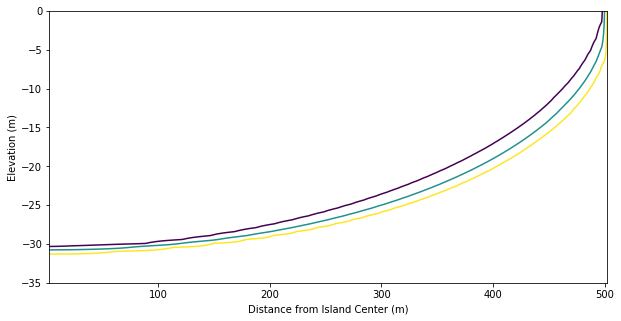

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
cs = ax.contour(np.flipud(conc), levels=[f * 35. for f in [.1, .5, .9]], 
                extent=[2.5, 502.5, -35, 0])
cs.collections[0].set_label('MF 6')
ax.set_xlabel('Distance from Island Center (m)')
ax.set_ylabel('Elevation (m)');

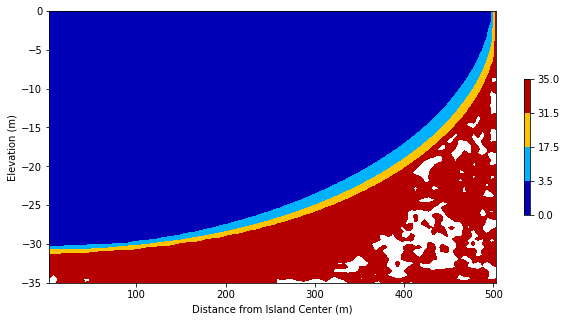

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
cs = ax.contourf(np.flipud(conc), levels=[f * 35. for f in [0, .1, .5, .9, 1.0]], 
                extent=[2.5, 502.5, -35, 0], cmap='jet')
ax.set_xlabel('Distance from Island Center (m)')
ax.set_ylabel('Elevation (m)')
plt.colorbar(cs, shrink=0.5);